In [1]:
%matplotlib inline
import sys
sys.path.append('..')

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, AveragePooling1D, Dropout, Flatten, BatchNormalization
from keras.layers import Activation
from keras.utils import to_categorical
from keras.layers.wrappers import TimeDistributed

Using TensorFlow backend.


In [2]:
from modules.factory import norm, fmeasure, recall, matthews_correlation
from collections import Counter
from sklearn.utils import shuffle, resample
from sklearn.metrics import roc_curve, auc, f1_score
from IPython.display import clear_output

### 0. Parameters

In [53]:
modelfile = '../data/keras models/40day-trend.h5'
rawfile = '../data/training set/daily-future-40day-trend.h5'
savefile = '../data/keras models/downtrend-predic(20-240-40).h5'
window = 20
seq_length = 240
trend_period = 40
time_step = 10
num_classes = 3

### 1. Data Loading & Reconstruction

#### A. Constructing Data

In [4]:
f = h5py.File(rawfile, 'r')

In [5]:
FILES = shuffle([i[1] for i in f.items()], random_state=2)

In [6]:
def preprocessing(file, seq_length, window, trend_period, time_step):
    raw_data = pd.DataFrame(file.value, columns=['open','high','low','close','trend'])
    trend = raw_data['trend']
    raw_data.drop('trend',axis=1,inplace=True)
    raw_data['pema5'] = raw_data.close/raw_data.close.ewm(span=5).mean()
    raw_data['pema20']= raw_data.close/raw_data.close.ewm(span=20).mean()
    raw_data['pema60']= raw_data.close/raw_data.close.ewm(span=60).mean()
    raw_data['pema120']= raw_data.close/raw_data.close.ewm(span=120).mean()
    
    #raw_data['ema20'] = raw_data.close.ewm(span=20).mean()
    #raw_data['ema60']= raw_data.close.ewm(span=60).mean()
    #raw_data['ema120']= raw_data.close.ewm(span=120).mean()
    X=[]
    Y=[]
    for i in range(0, len(raw_data)-(seq_length+window+trend_period), time_step):
        seq_data = raw_data[i:i+seq_length+window]
        normed = norm(seq_data, ntype='zscore')
        #normed['trend'] = trend
        
        seq=[]
        for k in range(window, seq_length+window):
            seq.append(normed[k-window:k].values)
            
        X.append(seq)
        Y.append(trend.iloc[i+window+seq_length+trend_period])
    
    return X,Y

In [7]:
def batch_generator(files, size=7, batch_size=16):
    for i in range(0, len(files), size):
        X=[]
        Y=[]
        
        for idx, file in enumerate(files[i:i+size]):
            print("\rpreprocessing..(%s/%s)"%(idx+1,size), end='', flush=True)
            x, y = preprocessing(file, seq_length, window, trend_period, time_step)
            X += x
            Y += y
            #clear_output(wait=True)
            
        batch_num = int(len(X)/batch_size)
        for i in range(0, batch_size*batch_num, batch_size):
            yield np.array(X[i:i+batch_size]), np.array(Y[i:i+batch_size])

In [82]:
%%time
X=[]
Y=[]
for idx,file in enumerate(FILES[40:50]):
    print('\rprocessing...(%s)'%idx, end='', flush=True)
    x,y = preprocessing(file, seq_length, window, trend_period, time_step)
    X += x
    Y += y
X = np.array(X)
Y = np.array(Y)

processing...(9)Wall time: 1min 36s


In [83]:
Counter(Y)

Counter({0.0: 348, 1.0: 1224, 2.0: 528})

In [84]:
#하락 추세
Y=np.where(Y==0, 1, 0)
#상승 추세
#Y=np.where(Y==2,1,0)

In [85]:
Counter(Y)

Counter({0: 1752, 1: 348})

In [74]:
#Resampling
negidx = np.where(Y==0)[0]
posidx = np.where(Y==1)[0]
resampled_neg = resample(X[negidx], n_samples=int(len(negidx)/3), replace=False)
resampled_y = np.zeros(len(resampled_neg), dtype='int')
X = np.append(X[posidx], resampled_neg, axis=0)
Y = np.append(Y[posidx], resampled_y)
X, Y = shuffle(X,Y)

#free memory
del resampled_neg, negidx, posidx, resampled_y

In [75]:
Counter(Y)

Counter({0: 579, 1: 307})

In [61]:
# seperate into train and test data
length = int(len(X) * 0.7)
x_train, x_test = X[:length], X[length:]
y_train, y_test = Y[:length], Y[length:]

In [50]:
Counter(y_test)

Counter({0.0: 1267, 1.0: 3290, 2.0: 1976})

### 2. Build a Model

In [199]:
model = Sequential()
model.add(TimeDistributed(Conv1D(32, 5, padding='same', activation='relu'), input_shape=X.shape[1:]))
model.add(TimeDistributed(AveragePooling1D(pool_size=2)))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv1D(64, 5, padding='same', activation='relu')))
model.add(TimeDistributed(AveragePooling1D(pool_size=2)))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))#, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics = ['accuracy', recall, fmeasure])

In [45]:
#load model
model = load_model(savefile, custom_objects={'recall':recall,'fmeasure':fmeasure})

sequential_4


### 3. Training

In [52]:
history = model.fit(X, Y, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
3830/3830 [==============================] - 119s - loss: 0.8778 - acc: 0.6238 - recall: 0.4016 - fmeasure: 0.4305   
Epoch 2/200
3830/3830 [==============================] - 119s - loss: 0.6033 - acc: 0.6828 - recall: 0.4555 - fmeasure: 0.5092   
Epoch 3/200
3830/3830 [==============================] - 126s - loss: 0.5564 - acc: 0.7128 - recall: 0.5143 - fmeasure: 0.5581   
Epoch 4/200
3830/3830 [==============================] - 147s - loss: 0.5046 - acc: 0.7493 - recall: 0.5711 - fmeasure: 0.6141   
Epoch 5/200
3830/3830 [==============================] - 173s - loss: 0.4513 - acc: 0.7901 - recall: 0.6464 - fmeasure: 0.6882   
Epoch 6/200
3830/3830 [==============================] - 124s - loss: 0.4066 - acc: 0.8141 - recall: 0.6786 - fmeasure: 0.7176   
Epoch 7/200
3830/3830 [==============================] - 125s - loss: 0.3759 - acc: 0.8326 - recall: 0.7151 - fmeasure: 0.7507   
Epoch 8/200
3830/3830 [==============================] - 124s - loss: 0.3324 - acc: 0.8559

3830/3830 [==============================] - 126s - loss: 0.0716 - acc: 0.9786 - recall: 0.9693 - fmeasure: 0.9708   
Epoch 64/200
3830/3830 [==============================] - 126s - loss: 0.0363 - acc: 0.9885 - recall: 0.9862 - fmeasure: 0.9842   
Epoch 65/200
3830/3830 [==============================] - 127s - loss: 0.0172 - acc: 0.9953 - recall: 0.9948 - fmeasure: 0.9933   
Epoch 66/200
3830/3830 [==============================] - 130s - loss: 0.0199 - acc: 0.9943 - recall: 0.9917 - fmeasure: 0.9926   
Epoch 67/200
3830/3830 [==============================] - 126s - loss: 0.0144 - acc: 0.9958 - recall: 0.9920 - fmeasure: 0.9941   
Epoch 68/200
3830/3830 [==============================] - 126s - loss: 0.0158 - acc: 0.9958 - recall: 0.9933 - fmeasure: 0.9937   
Epoch 69/200
3830/3830 [==============================] - 130s - loss: 0.0177 - acc: 0.9945 - recall: 0.9897 - fmeasure: 0.9916   
Epoch 70/200
3830/3830 [==============================] - 127s - loss: 0.0761 - acc: 0.9739 - re

3830/3830 [==============================] - 127s - loss: 0.0742 - acc: 0.9773 - recall: 0.9638 - fmeasure: 0.9680   
Epoch 126/200
3830/3830 [==============================] - 128s - loss: 0.0366 - acc: 0.9885 - recall: 0.9823 - fmeasure: 0.9846   
Epoch 127/200
3830/3830 [==============================] - 129s - loss: 0.0179 - acc: 0.9937 - recall: 0.9926 - fmeasure: 0.9911   
Epoch 128/200
3830/3830 [==============================] - 128s - loss: 0.0141 - acc: 0.9950 - recall: 0.9932 - fmeasure: 0.9932   
Epoch 129/200
3830/3830 [==============================] - 126s - loss: 0.0143 - acc: 0.9953 - recall: 0.9949 - fmeasure: 0.9939   
Epoch 130/200
3830/3830 [==============================] - 127s - loss: 0.0154 - acc: 0.9948 - recall: 0.9926 - fmeasure: 0.9933   
Epoch 131/200
3830/3830 [==============================] - 127s - loss: 0.0130 - acc: 0.9961 - recall: 0.9929 - fmeasure: 0.9944   
Epoch 132/200
3830/3830 [==============================] - 126s - loss: 0.0083 - acc: 0.99

3830/3830 [==============================] - 125s - loss: 0.0093 - acc: 0.9979 - recall: 0.9971 - fmeasure: 0.9966   
Epoch 188/200
3830/3830 [==============================] - 125s - loss: 0.0071 - acc: 0.9982 - recall: 0.9982 - fmeasure: 0.9977   
Epoch 189/200
3830/3830 [==============================] - 127s - loss: 0.0231 - acc: 0.9922 - recall: 0.9919 - fmeasure: 0.9892   
Epoch 190/200
3830/3830 [==============================] - 126s - loss: 0.0262 - acc: 0.9909 - recall: 0.9898 - fmeasure: 0.9880   
Epoch 191/200
3830/3830 [==============================] - 126s - loss: 0.0292 - acc: 0.9916 - recall: 0.9877 - fmeasure: 0.9879   
Epoch 192/200
3830/3830 [==============================] - 126s - loss: 0.0126 - acc: 0.9963 - recall: 0.9966 - fmeasure: 0.9955   
Epoch 193/200
3830/3830 [==============================] - 126s - loss: 0.0110 - acc: 0.9958 - recall: 0.9931 - fmeasure: 0.9940   
Epoch 194/200
3830/3830 [==============================] - 129s - loss: 0.0171 - acc: 0.99

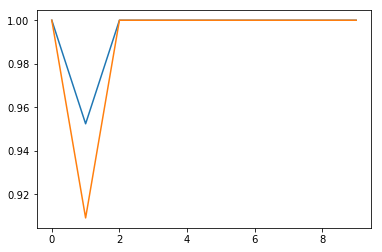

In [88]:
plt.plot(history.history['fmeasure'])
plt.plot(history.history['recall'])

In [172]:
score = model.evaluate(X, Y, batch_size=32)
print('\nTest score:', score)

3354/3354 [==============================] - 32s    

Test score: [2.0653310151205364, 0.63029218853835056, 0.50379585864363363, 0.50160900396325436]


In [43]:
model.name

'downtrend'

In [54]:
model.save(savefile)

### 4. Verification - ROC curve

In [86]:
predic = model.predict(X, verbose=1)

2100/2100 [==============================] - 20s    


In [87]:
pred = predic.squeeze()
pred = np.where(pred>0.5, 1, 0)

In [88]:
Counter(pred)

Counter({0: 1525, 1: 575})

In [89]:
Counter(Y)

Counter({0: 1752, 1: 348})

In [90]:
f1_score(Y,pred) 

0.7518959913326112

In [91]:
ids = np.where(pred==1)
Counter(Y[ids])

Counter({0: 228, 1: 347})

In [69]:
ids = np.where(pred==0)[0]

In [70]:
ids.shape

(1567,)

In [180]:
Counter(real[ids])

NameError: name 'real' is not defined

In [71]:
Counter(pred)

Counter({0: 1567, 1: 479})

In [92]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(Y, predic, pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

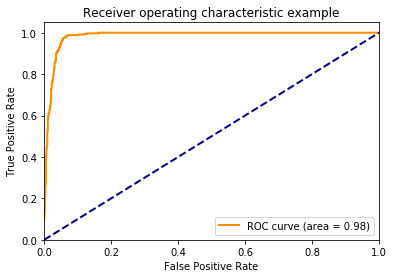

In [93]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 5. Verification - Real Data

In [9]:
model = load_model(savefile, custom_objects={'matthews_correlation': matthews_correlation, 'recall': recall, 'fmeasure':fmeasure})

In [159]:
import time

Predic:  [  7.57106989e-07]
Real:  0.0


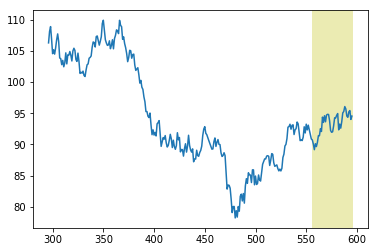

q


In [183]:
while True:
    file = np.random.choice(FILES[:20])
    raw_data = pd.DataFrame(file.value, 
                            columns=['open','high','low','close','trend'])
    trend = raw_data['trend']
    raw_data.drop('trend',axis=1, inplace=True)
    
    raw_data['ema5'] = raw_data.close/raw_data.close.ewm(span=5).mean()
    raw_data['ema20']= raw_data.close/raw_data.close.ewm(span=20).mean()
    raw_data['ema60']= raw_data.close/raw_data.close.ewm(span=60).mean()
    raw_data['ema120']= raw_data.close/raw_data.close.ewm(span=120).mean()

    start = np.random.randint(0, len(raw_data)-seq_length-trend_period-window)
    endseq = start + seq_length
    endtrend = endseq + trend_period 
    
    seq_data = raw_data[start:start+seq_length+window]
    
    normed = norm(seq_data, ntype='zscore')
    seq=[]
    for k in range(window, seq_length+window):
        seq.append(normed[k-window:k].values)
    
    #normed['ema5'] = raw_data.ema5[start:endseq]
    #normed['ema20'] = raw_data.ema20[start:endseq]
    #normed['ema60'] = raw_data.ema60[start:endseq]
    #normed['trend'] = seq_data['trend']
    predic = model.predict(np.array([seq]))[0]
    
    print("Predic: ", predic)
    #print("Predic:", predic.argmax())
    print("Real: ", trend.iloc[start+seq_length+window+trend_period]-1)
    
    plt.figure()
    plt.plot(raw_data.close[start:start+seq_length+window+trend_period])
    plt.axvspan(start+seq_length+window,start+seq_length+window+trend_period, facecolor='y', alpha=0.3)
    plt.show()
    #fig, (ax) = plt.subplots(1,2, figsize=(20,5))
    
    #ax[0].plot(test_x[i,:,3])
    #ax[1].plot(test_x[i+60,:,3])
    #ax[1].axvspan(120,180, facecolor='y', alpha=0.3 )
    #plt.show()
    #time.sleep(0.1)
    key = input()
    if key == 'q':
        break
    clear_output(wait=True)

In [308]:
start

314

In [109]:
pd.ewma(raw_data.close, span=10).mean()

C:\Python\Miniconda64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=10,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


3.33612269013754

In [164]:
np.array(seq).shape

(240, 20, 8)

In [112]:
raw_data

,open,high,low,close,downtrend,uptrend,ema
0,1.4960,1.4980,1.4740,1.4870,2.739136e-04,8.848447e-01,1.487000
1,1.4890,1.4900,1.4570,1.4645,1.595031e-05,5.139159e-03,1.474625
2,1.4540,1.4630,1.4270,1.4595,1.839598e-04,8.178793e-01,1.468545
3,1.4560,1.4590,1.4390,1.4465,2.277036e-04,7.696805e-03,1.461282
4,1.4530,1.4720,1.4500,1.4595,9.120651e-04,4.928198e-05,1.460770
5,1.4570,1.4650,1.4440,1.4590,7.089793e-06,1.495185e-06,1.460311
6,1.4530,1.4580,1.4420,1.4580,3.719399e-04,1.358987e-07,1.459754
7,1.4670,1.4990,1.4550,1.4960,1.779208e-03,1.010162e-06,1.468000
8,1.4890,1.4950,1.4790,1.4935,9.425099e-07,2.659535e-06,1.473548
9,1.4970,1.5190,1.4960,1.5105,6.485791e-06,3.234991e-05,1.481310
